In [1]:
import json, random, time
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import re
from nltk.corpus import stopwords
import pickle
import pylcs
np.set_printoptions(precision=4)

In [10]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [3]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0819_16neg.json", "r"))
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_0819_16neg.json", "r"))

print(Counter([txt_dataset[k]['split'] for k in txt_dataset]))
print(len(set([txt_dataset[k]['Guid'] for k in txt_dataset])))

print(Counter([img_dataset[k]['split'] for k in img_dataset]))
print(Counter([img_dataset[k]['Qcate'] for k in img_dataset]))
print(len(set([img_dataset[k]['Guid'] for k in img_dataset])))

Counter({'train': 17812, 'test': 4824, 'val': 2455})
25091
Counter({'train': 16448, 'ood_test': 3948, 'val': 2511, 'ind_test': 2485})
Counter({'YesNo': 8410, 'Others': 6689, 'choose': 5226, 'number': 2337, 'color': 2068, 'shape': 662})
25392


Q_txt_data 25091
A_txt_data 45956
Q_img_data 25392
A_img_data 57297
Q_txt_data 24.287194611613725 9.566567258113531
A_txt_data 16.401144573069892 14.157306294648217
Q_img_data 23.559664461247635 7.446425984176793
A_img_data 21.118051555927885 8.01316121963303


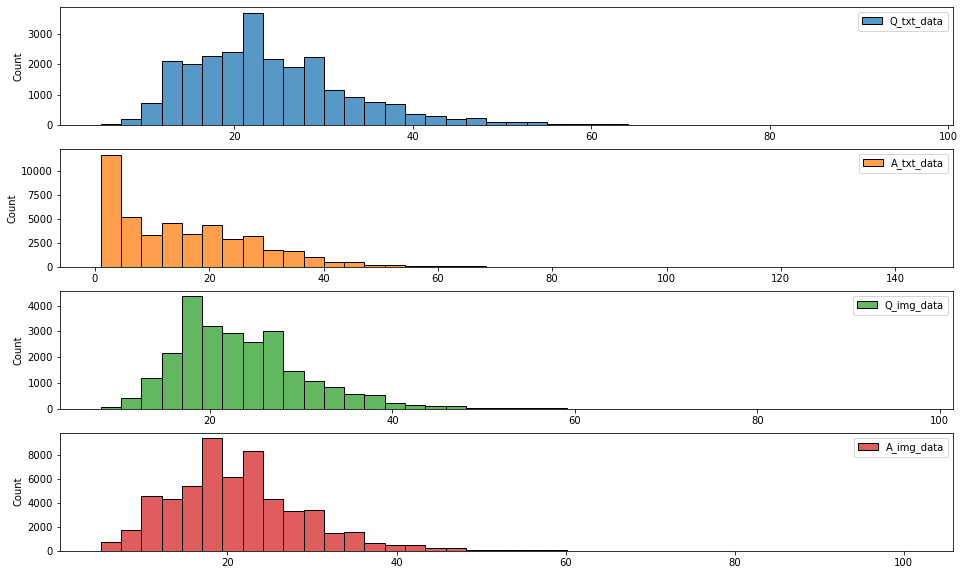

In [11]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'Q_txt_data': [], 'A_txt_data': [], 'Q_img_data': [], 'A_img_data': []}
for k in txt_dataset:
    snippet_lengths['Q_txt_data'].append(len(tokenizer.tokenize(txt_dataset[k]['Q'])))
    snippet_lengths['A_txt_data'].extend([len(tokenizer.tokenize(a)) for a in txt_dataset[k]['A']])
for k in img_dataset:
    snippet_lengths['Q_img_data'].append(len(tokenizer.tokenize(img_dataset[k]['Q'])))
    snippet_lengths['A_img_data'].extend([len(tokenizer.tokenize(a)) for a in img_dataset[k]['A']])
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(16,10))
for i, k, color in zip(range(4), list(snippet_lengths.keys()), colors[:4]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

In [ ]:
Q_txt_data 25091
A_txt_data 45956
Q_img_data 25392
A_img_data 57297
Q_txt_data 23.46602367382727 9.276406800861304
A_txt_data 15.714161371746888 13.685776848253361
Q_img_data 22.71195652173913 7.043431433240292
A_img_data 20.377401958217707 7.632208562214467

In [12]:
print("\nImg data, num(img_posFacts): ")
x = [len(img_dataset[k]['img_posFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(img_negFacts): ")
x = [len(img_dataset[k]['img_negFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(txt_negFacts): ")
x = [len(img_dataset[k]['txt_negFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))


Img data, num(img_posFacts): 
Counter({1: 14285, 2: 11107})
1.4374212350346567 2 1

Img data, num(img_negFacts): 
Counter({16: 24233, 13: 801, 12: 101, 15: 84, 14: 79, 11: 70, 7: 15, 10: 4, 8: 3, 9: 2})
15.858380592312539 16 7

Img data, num(txt_negFacts): 
Counter({16: 23344, 0: 151, 12: 142, 13: 141, 14: 139, 15: 138, 1: 133, 11: 132, 6: 131, 10: 129, 8: 128, 5: 120, 2: 120, 7: 115, 9: 114, 3: 108, 4: 107})
15.326283868935098 16 0


In [13]:
print("\ntxt data, num(txt_posFacts): ")
x = [len(txt_dataset[k]['txt_posFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(img_negFacts): ")
x = [len(txt_dataset[k]['img_negFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(txt_negFacts): ")
x = [len(txt_dataset[k]['txt_negFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))


txt data, num(txt_posFacts): 
Counter({2: 24158, 3: 883, 4: 46, 1: 3, 5: 1})
2.0388585548603086 5 1

txt data, num(img_negFacts): 
Counter({16: 14171, 5: 934, 6: 868, 7: 802, 8: 781, 1: 779, 9: 751, 3: 712, 2: 709, 10: 695, 4: 664, 11: 651, 13: 572, 12: 563, 14: 550, 15: 519, 0: 370})
12.196086246064326 16 0

txt data, num(txt_negFacts): 
Counter({16: 19693, 10: 497, 8: 494, 7: 488, 13: 484, 9: 480, 6: 456, 11: 455, 12: 446, 15: 445, 5: 435, 14: 425, 4: 235, 3: 56, 2: 2})
14.62847236060739 16 2


In [6]:
img_topics = Counter([img_dataset[k]['topic'] for k in img_dataset])
print(img_topics.most_common(20))

[('Other', 2345), ('streets', 2283), ('plaza', 1302), ('downtown', 828), ('mushroom', 818), ('bird', 786), ('car', 709), ('tourist attractions', 626), ('vista', 617), ('civic center', 585), ('Christ Church Cathedral', 566), ('public art', 561), ('museum', 529), ('world expo pavilion', 518), ('tech institute', 506), ('flora', 493), ('Neoclassicism art', 486), ('modern artwork', 467), ('olympics opening ceremony', 465), ('strange architecture', 464)]


pos_imgs 36499
neg_imgs_for_img 402676
neg_imgs_for_txt 306012
pos_imgs 12.30099454779583 7.765564270240925
neg_imgs_for_img 12.397744092024357 7.698023111268652
neg_imgs_for_txt 16.255391945413905 14.960496954852308


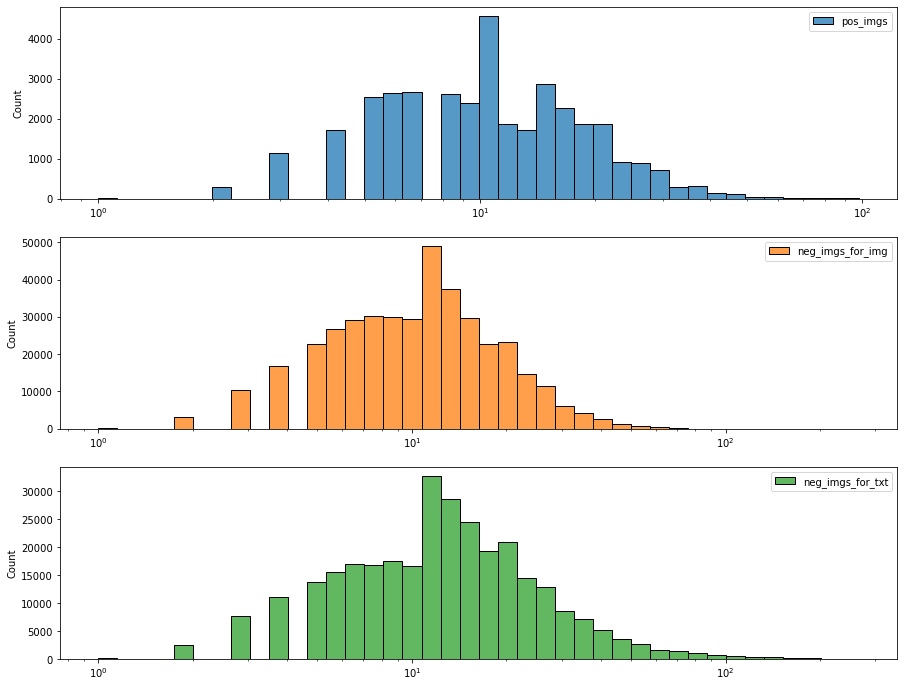

In [14]:
### Comparison of length distribution of img captions: 
# with pos imgs || with neg imgs for img data || with neg imgs for txt data
cap_lengths = {'pos_imgs': [], 'neg_imgs_for_img': [], 'neg_imgs_for_txt': []}
for k in img_dataset:
    for i in img_dataset[k]['img_posFacts']:
        cap_lengths['pos_imgs'].append(len(tokenizer.tokenize(i['caption'].strip())))
    for i in img_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_img'].append(len(tokenizer.tokenize(i['caption'].strip())))
for k in txt_dataset:
    for i in txt_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_txt'].append(len(tokenizer.tokenize(i['caption'].strip())))
        
for k in cap_lengths:
    print(k, len(cap_lengths[k]))
for k in cap_lengths:
    print(k, np.mean(cap_lengths[k]), np.std(cap_lengths[k]))

colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(cap_lengths.keys()), colors[:3]):
    ax = axes[i]
    ax.set(xscale="log")
    sns.histplot(cap_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

pos_snippets 51157
neg_snippets_for_img 389165
neg_snippets_for_txt 367043
pos_snippets 65.1993080125887 19.318142912080013
neg_snippets_for_img 49.77208639009161 15.329551310541113
neg_snippets_for_txt 53.69521554695226 17.59853316343298


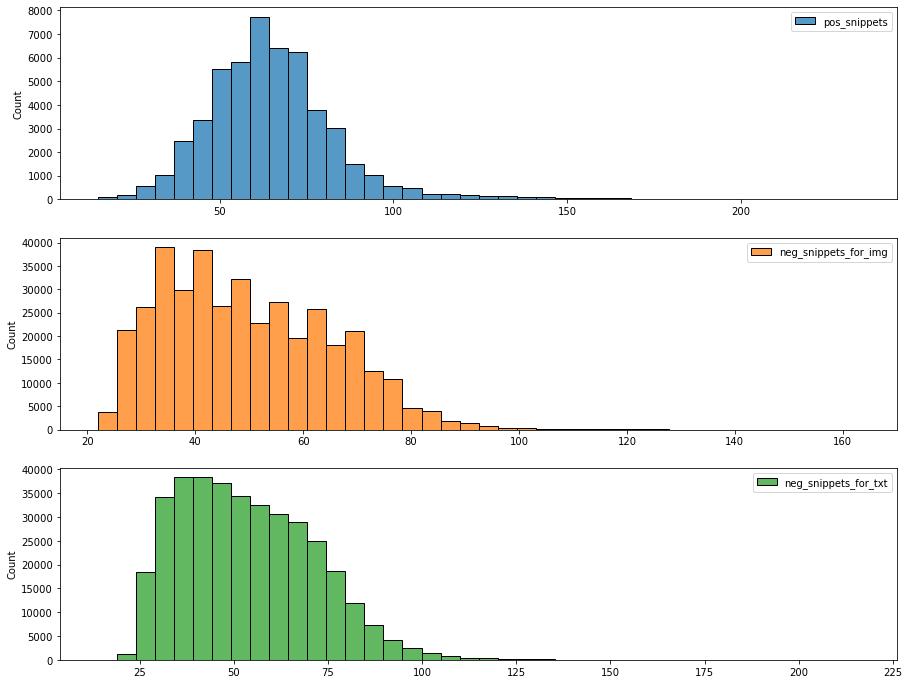

In [15]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'pos_snippets': [], 'neg_snippets_for_img': [], 'neg_snippets_for_txt': []}
for k in txt_dataset:
    for f in txt_dataset[k]['txt_posFacts']:
        snippet_lengths['pos_snippets'].append(len(tokenizer.tokenize(f['fact'])))
    for f in txt_dataset[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_txt'].append(len(tokenizer.tokenize(f['fact'])))
for k in img_dataset:
    for f in img_dataset[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_img'].append(len(tokenizer.tokenize(f['fact'])))
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(snippet_lengths.keys()), colors[:3]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

In [9]:
img_dataset['0'].keys()

dict_keys(['Q', 'A', 'Qtype', 'topic', 'split', 'Qcate', 'Guid', 'word_lists', 'Keywords_A', 'img_posFacts', 'img_negFacts', 'txt_negFacts'])